In [6]:
import sqlite3
import os.path
import numpy as np
import math
import cv2
import dlib
import aflw

In [7]:
# random and write       
aflw_db_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/aflw.sqlite'
aflw_dir_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/flickr'
raw_aflw = aflw.load_raw_aflw(aflw_db_path, aflw_dir_path)

Load raw AFLW dataset from "/home/lmiguel/Projects/datasets/aflw/aflw/data/aflw.sqlite"
Invalid face id (65385) in AFLW
Invalid face id (65386) in AFLW
Invalid face id (65387) in AFLW
Invalid face id (65388) in AFLW
Invalid face id (65389) in AFLW
Invalid face id (65390) in AFLW
Invalid face id (65391) in AFLW
Invalid face id (65392) in AFLW
Invalid face id (65393) in AFLW
Invalid face id (65394) in AFLW
Invalid face id (65395) in AFLW
Invalid face id (65396) in AFLW


La generación de imágenes positivas como negativas no es exacta, en otros trabajos se toma el resultado directo de los landmarks y a partir de este se construye el rect para el rostro, en Hyperface (supongo por el SS que se usa para proponer las regiones) se usa el resultado del SS -un problema de huevo y gallina-. 
Además, usar SS produce muchos negativos, cuando minsize es _40*40_ se producen negativos en un ratio 1:50 sin contar que no se detecta positivos en la mitad de las imágenes, si se disminuye este ratio a _20*20_ el ratio es de 1:100 con 70% de imágenes sin positivos. Estos ratio son usando NMS. Si no se usa NMS este ratio se dispara (1:150 para _40*40_ con 5 veces más positivos).

In [9]:
positive_faces, negative_faces = aflw.setup_raw_aflw(raw_aflw, 
                                                     log_interval=500,
                                                     max_iterations=5000,
                                                     overlap_positive_face_rate=0.75,
                                                     overlap_negative_face_rate=0.2,
                                                     ss_max_img_size=(400, 400),
                                                     ss_kvals=(40, 200, 2),
                                                     ss_min_size=40*40,
                                                     apply_nms=True)

Calculate selective search rectangles for AFLW
 0/24384


/home/lmiguel/Projects/hyperface/HyperFace-with-SqueezeNet/aflw.py:396: RuntimeWarning: invalid value encountered in true_divide
  overlap = (w * h) / area[idxs[:last]]
/home/lmiguel/Projects/hyperface/HyperFace-with-SqueezeNet/aflw.py:400: RuntimeWarning: invalid value encountered in greater
  np.where(overlap > overlapThresh)[0])))


 500/24384
 1000/24384
 1500/24384
 2000/24384
 2500/24384
 3000/24384
 3500/24384
 4000/24384
 4500/24384
Found 2884 positive samples and 113749 negative samples.
2989 images have 0 positives.


Generemos el dataset en JSON

In [19]:
import random

test_rate = 0.04

positive_n_train = int(len(positive_faces) * (1.0 - test_rate))
positive_n_test = len(positive_faces) - positive_n_train
positive_faces_train = random.sample(positive_faces[0:positive_n_train], positive_n_train)
positive_faces_test = random.sample(positive_faces[positive_n_train:positive_n_train+positive_n_test], positive_n_test)

negative_n_train = int(len(negative_faces) * (1.0 - test_rate))
negative_n_test = len(negative_faces) - negative_n_train
negative_faces_train = random.sample(negative_faces[0:negative_n_train], negative_n_train)
negative_faces_test = random.sample(negative_faces[negative_n_train:negative_n_train+negative_n_test], negative_n_test)

In [20]:
import json

with open('positives5k-train.json', 'w') as fp:
    json.dump(positive_faces_train, fp)
with open('positives5k-test.json', 'w') as fp:
    json.dump(positive_faces_test, fp)    
with open('negatives5k-train.json', 'w') as fp:
    json.dump(negative_faces_train, fp)
with open('negatives5k-test.json', 'w') as fp:
    json.dump(negative_faces_test, fp)

Como se puede apreciar las regiones propuestas por SS no son exactas. En un trabajo futuro se debería usar directamente los resultados de las anotaciones para armar los rostros.

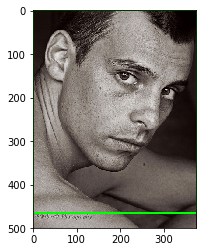

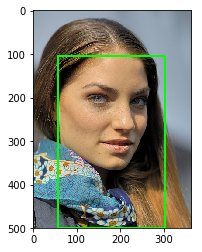

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

for face in positive_faces:
    img_path = face['image']
    rect = face['bbox']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    p1 = (rect[0], rect[1])
    p2 = (rect[0] + rect[2], rect[1] + rect[3])
    cv2.rectangle(img, p1, p2, (0, 255, 0), thickness=3)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)

Usando SS (Selective Search) con NMS (Non-maxima supression) para reducir el número de propuesta de región.

120 rectangles
67 rectangles


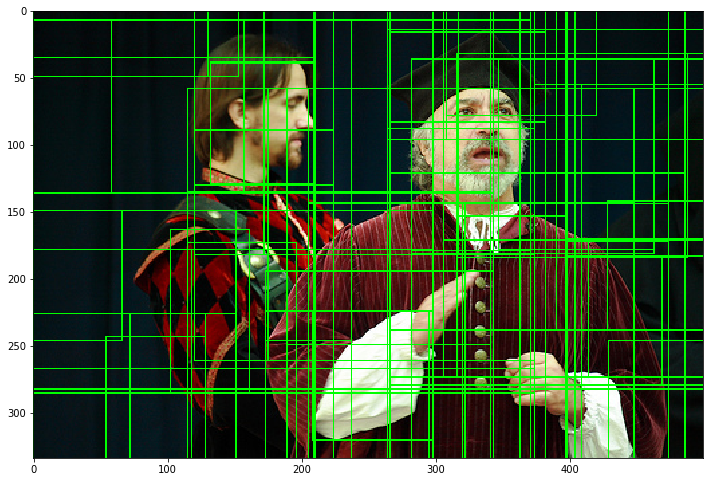

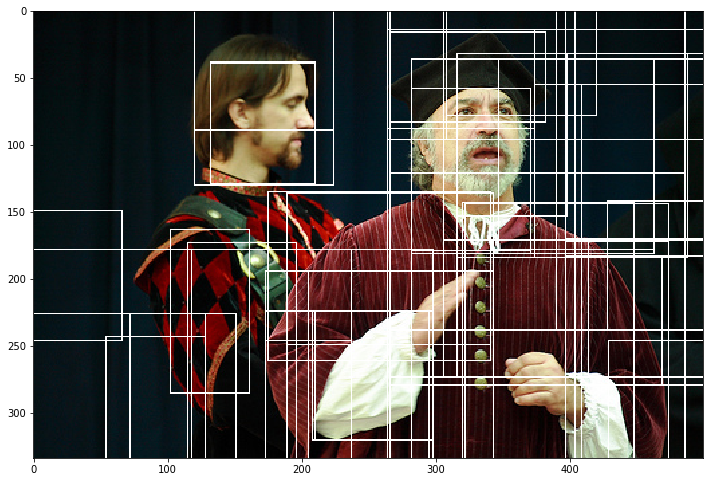

In [58]:
aflw_db_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/aflw.sqlite'
aflw_dir_path = '/home/lmiguel/Projects/datasets/aflw/aflw/data/flickr'
img_path = os.path.join(aflw_dir_path, '3/image03350.jpg')

import cv2
import matplotlib.pyplot as plt


img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rects = selective_search_dlib(img)
print(len(rects), "rectangles")
for rect in rects:
    p1 = (rect[0], rect[1])
    p2 = (rect[0] + rect[2], rect[1] + rect[3])
    cv2.rectangle(img, p1, p2, (0, 255, 0))

plt.figure(figsize=(12, 12))
plt.imshow(img)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rects = non_max_suppression_fast(np.array(rects), 0.5)
print(len(rects), "rectangles")
for rect in rects:
    p1 = (rect[0], rect[1])
    p2 = (rect[0] + rect[2], rect[1] + rect[3])
    cv2.rectangle(img, p1, p2, (255, 255, 255))

plt.figure(figsize=(12, 12))
plt.imshow(img)
